### Event 1: Birth - $X -> X + 1$
- Rate  1: $\mu N$

### Event 2: Transmission - $Y -> Y + 1$ & $X -> X - 1$
- Rate  2: $\beta{XY \over N}$

### Event 3: Recovery - $Y -> Y - 1$
- Rate 3: $\gamma Y$

### Event 4: Death
1. $X -> X - 1$
    - $\mu X$
2. $Y -> Y - 1$
    - $\mu Y$
3. $Z -> Z - 1$
    - $\mu Z$



In [41]:
from typing import List, Tuple

from math   import log, inf, isinf
from random import random

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

%matplotlib widget


class Gillespie:
    BIRTH        = 0
    TRANSMISSION = 1
    RECOVERY     = 2
    DEATH_SUS    = 3
    DEATH_INF    = 4
    DEATH_RES    = 5
    DEATH_GEN    = 6

    def __init__(self, beta: float, gamma: float, mu: float, nSusceptible: int, nInfected: int, nResistent: int) -> None:
        self._beta  = beta
        self._gamma = gamma
        self._mu    = mu

        self._nSus = nSusceptible
        self._nInf = nInfected
        self._nRes = nResistent

        self._nPop = nSusceptible + nInfected + nResistent

        self._time = 0.0
    
    def seedInfection(self, nPop = 1) -> int:
        """
        Infect a portion of the susceptible population

        Args:
            nPop: population to infect (Default: 1)
        
        Returns (int):
            The amount of Susceptibles infected.
        """
        if nPop > self._nSus:
            nPop = self._nSus

        self._nInf += nPop
        self._nSus -= nPop

        return nPop

    def get_rateBirth(self) -> float:
        """Returns the rate of birth for the current population"""
        return self._mu * self._nPop
    
    def get_rateTransmission(self) -> float:
        """Return the rate of transmission for the current population"""
        return self._beta * ((self._nSus * self._nInf) / self._nPop)
    
    def get_rateRecovery(self) -> float:
        """Returns the rate of recovery for the current population"""
        return self._gamma * self._nInf
    
    def get_rateDeathGen(self) -> float:
        return self._mu * self._nPop

    def get_rateDeathSus(self) -> float:
        return (self._mu * self._nSus)
    
    def get_rateDeathInf(self) -> float:
        return (self._mu * self._nInf)
    
    def get_rateDeathRes(self) -> float:
        return (self._mu * self._nRes)
    
    def get_rates(self) -> List[Tuple[int, float]]:
        return [
                (self.BIRTH,        self.get_rateBirth()       ), 
                (self.TRANSMISSION, self.get_rateTransmission()), 
                (self.RECOVERY,     self.get_rateRecovery()    ), 
                (self.DEATH_GEN,    self.get_rateDeathGen()    )
            ]
    
    def get_deatRates(self) -> List[Tuple[int, float]]:
        return [
            (self.DEATH_SUS, self.get_rateDeathSus()),
            (self.DEATH_INF, self.get_rateDeathInf()),
            (self.DEATH_RES, self.get_rateDeathRes())
        ]
    
    def calcRandomDeltaT(self, rate: float) -> float:
        if rate <= 0: 
            return inf
        return -1 / (rate * log(random()))
    
    def updatePopulations(self, event: int) -> None:
        match event:
            case self.BIRTH:
                self._nSus += 1

                self._nPop += 1

            case self.TRANSMISSION:
                self._nSus -= 1
                self._nInf += 1

            case self.RECOVERY:
                self._nInf -= 1
                self._nRes += 1

            case self.DEATH_SUS:
                self._nSus -= 1

                self._nPop -= 1

            case self.DEATH_INF:
                self._nInf -= 1

                self._nPop -= 1
            
            case self.DEATH_RES:
                self._nRes -= 1

                self._nPop -= 1

    def propagateModel(self) -> int:
        minDelta: float = -1
        for event, rate in self.get_rates():
            newDelta = self.calcRandomDeltaT(rate)
        
            if (newDelta < minDelta) or minDelta == -1:
                minDelta = newDelta
                nextEvent = event
        
        if nextEvent == self.DEATH_GEN:
            minDelta: float = -1
            for event, rate in self.get_deatRates():
                newDelta = self.calcRandomDeltaT(rate)
        
                if (newDelta < minDelta) or minDelta == -1:
                    minDelta = newDelta
                    nextEvent = event

        self.updatePopulations(nextEvent)
        self._time += minDelta

        return minDelta

    def get_plotPoints(self) -> Tuple[float, int, int, int, int]:
        return self._time, self._nSus, self._nInf, self._nRes, self._nPop

def runTimedGillespie(model: Gillespie, tmax = 100) -> List[Tuple[float, int, int, int, int]]:
    outData = [model.get_plotPoints()]
    time = outData[-1][0]
    checkin = 10

    while time < tmax:
        if outData[-1][-1] == 0:
            break
        model.propagateModel()
        outData.append(model.get_plotPoints())
    
        time, _, inf, _, pop = outData[-1]
    return outData

def plotGillespieData(inData: List[Tuple[float, int, int, int, int]]):
    fig, ax = plt.subplots()

    assert(isinstance(ax, plt.Axes))
    
    times        = [time for time, sus, inf, res, pop in inData]
    susceptibles = [sus  for time, sus, inf, res, pop in inData]
    infecteds    = [inf  for time, sus, inf, res, pop in inData]
    resistants   = [res  for time, sus, inf, res, pop in inData]
    populations  = [pop  for time, sus, inf, res, pop in inData]

    ax.plot(times, susceptibles, label="Susceptible pop.")
    ax.plot(times, infecteds,    label="Infected pop.")
    ax.plot(times, resistants,   label="Resistant pop.")
    ax.plot(times, populations,  label="Total Pop.")

    ax.legend()


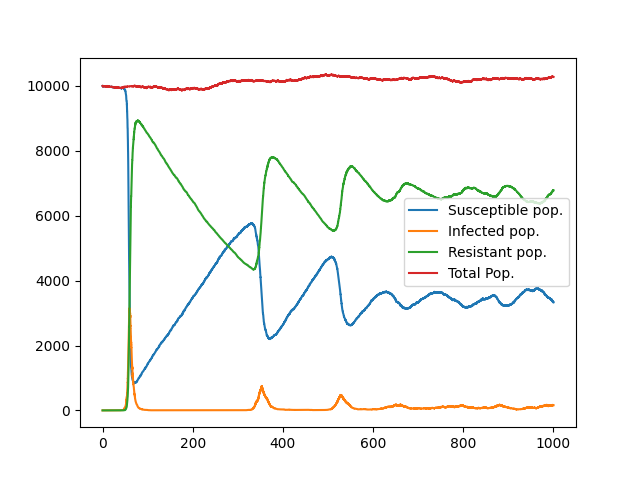

In [78]:
model = Gillespie(3, 1, 1/80, 10000, 0, 0)
model.seedInfection(1)

data = runTimedGillespie(model, 1000)

plotGillespieData(data)